In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

In [2]:
def theta_dist(theta,nu_type,case):
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nubar_e":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
    else:
        print("Not a valid angular distribution!")

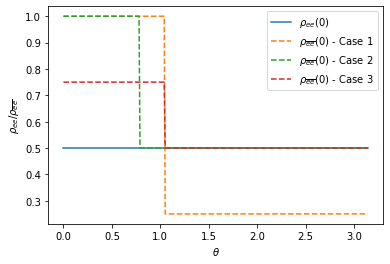

In [3]:
theta_vec=np.arange(0,math.pi,0.01)
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nubar_e",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

In [68]:
def initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case):
    y0=[] #Initial state
    flavor_sign=1
    omega=delta_m2_31/(2*E_nu*10**6) #eV 

    theta_vec=np.arange(0,np.pi,theta_step)
    n_theta=len(theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1

    for i in range(n_theta):        
      for j in range(n_f):
        if nu_types[j]=="nu_x":
          flavor_sign=-1
        if nu_types[j]=="nu_e":
          flavor_sign=1
        #nu
        nu_spec=theta_dist(theta_vec[i],"nu_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)
        #nubar
        nu_spec=theta_dist(theta_vec[i],"nubar_e",case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign*nu_spec)

    #r array
    t_i = (t_i*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_f = (t_f*3*10**5)*from_eV_to_1_over_km #eV⁻¹
    t_step = t_f/1000 #eV⁻¹
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,theta_vec

In [69]:
t_i,t_f=0,5*10**(-6)
case=1
E_nu=10 #MeV
theta_step=0.01

mu_0=10**3 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km
nu_types=['nu_e','nu_x']

y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

In [45]:
def func_Collective_nu(y, time, params):
    omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    B=np.array(B_vec(n_dim,theta_31))
    L=np.array(L_vec(n_dim))
    
#     r=time/from_eV_to_1_over_km #From eV⁻¹ to km
#     mu=mu_supernova(r,mu_opt,mu_0)
    mu=mu_0
    lamb=lambda_supernova(t,"no",0)
    
    derivs=[]
    nu, nubar = [],[]
    num_diff_nu_compnents=2*n_f*n_dim

    #Filling [Theta bin][Nu_types][3components]
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*num_diff_nu_compnents)+k+2*j*n_dim
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*num_diff_nu_compnents)+(k+n_dim)+2*j*n_dim
          nubar[i][j].append(y[nubar_index])
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
    
    B=np.array(B)
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        
        aux=B*omega+L*lamb-mu*(nu_sum-nubar_sum)
        P_aux= cross_prod(nu[i][j],aux)
        #P_aux= cross_prod(nu[i][j],(B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        P_aux= cross_prod(nubar[i][j],(-1*B*omega+L*lamb-mu*(nu_sum-(nubar_sum-nubar[i][j]))))
        #P_aux= cross_prod(nubar[i][j],(-1*B*omega[i]+L*lamb-mu*(nu_sum-nubar_sum)))
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [46]:
mass_ord="NH"
y0,omega,E,t,mu_0,n_f,n_dim,n_theta=initiate(nu_types,t_i,t_f,E_nu,mu_0,theta_step,case)

if mass_ord=="NH": 
    params=omega,E,t,mu_0,n_f,n_dim,n_theta
elif mass_ord=="IH":
    params=-1*omega,E,t,mu_0,n_f,n_dim,n_theta
else:
    print("Not a mass ordering option!")
psoln= odeint(func_Collective_nu, y0, t, args=(params,))

In [47]:
nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))

In [48]:
nu_e_time,nubar_e_time,nu_x_time,nubar_x_time=read_two_flavor_v1(nu, nubar)

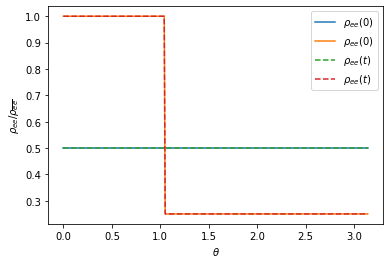

In [56]:
theta_vec=np.arange(0,np.pi,theta_step)
plt.plot(theta_vec,np.array(nu_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu_e_time[-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.plot(theta_vec,np.array(nubar_e_time[-1])/theta_step,ls='--',label=r"$\rho_{ee}(t)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

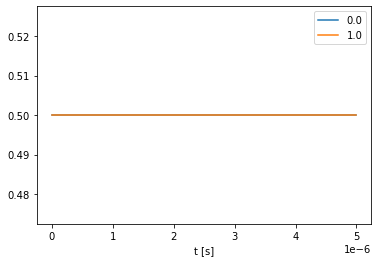

In [60]:
nu_e_theta=np.transpose(nu_e_time,(1,0))
plt.plot(t/from_eV_to_1_over_km/(3*10**5),np.array(nu_e_theta[0])/theta_step,label=theta_vec[0])
plt.plot(t/from_eV_to_1_over_km/(3*10**5),np.array(nu_e_theta[100])/theta_step,label=theta_vec[100])
plt.xlabel(r"t [s]")
plt.legend()
plt.show()

In [67]:
print(omega)
print(2*math.pi/(omega*from_eV_to_1_over_km*3*10**(5)))
print(mu_0)

1.25e-10
3.306069617037404e-05
1.973164956590371e-07
